# Retail Dataset

This dataset contains lot of historical sales data. It was extracted from a Brazilian top retailer and has many SKUs and many stores. The data was transformed to protect the identity of the retailer.

## 1. Load 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import calendar
import datetime  
from datetime import datetime as dt
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM, Conv1D, Flatten, Dropout, MaxPooling1D, RepeatVector, TimeDistributed, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(124)
import tensorflow as tf

tf.random.set_seed(124)
import warnings 
warnings.filterwarnings("ignore")


In [2]:
retail = pd.read_csv('../dataset/mock_retail_sales.csv.zip')

In [3]:
retail.columns = ['date', 'sale', 'stock', 'price']

In [4]:
retail['date'] = pd.to_datetime(retail['date'])

## 2. Explore Dataset

In [5]:
retail.head()

,date,sale,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [6]:
retail.tail()

,date,sale,stock,price
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39
936,2016-07-31,183,3642,2.39


In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    937 non-null    datetime64[ns]
 1   sale    937 non-null    int64         
 2   stock   937 non-null    int64         
 3   price   937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB


In [8]:
retail.describe()

,sale,stock,price
count,937.000000,937.000000,937.000000
mean,90.533618,1608.258271,1.592572
std,80.682089,1356.691877,0.529502
min,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000
50%,76.000000,1348.000000,1.390000
75%,127.000000,1964.000000,1.890000
max,542.000000,7228.000000,2.980000


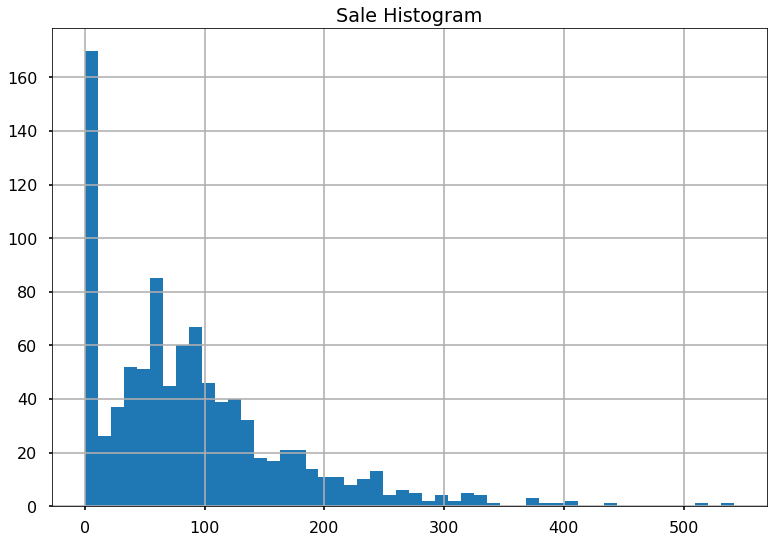

In [9]:
with plt.style.context("seaborn-poster"):
    fig, ax = plt.subplots()
    ax.set_title('Sale Histogram')
    retail["sale"].hist(ax=ax, bins=50)
    plt.show()

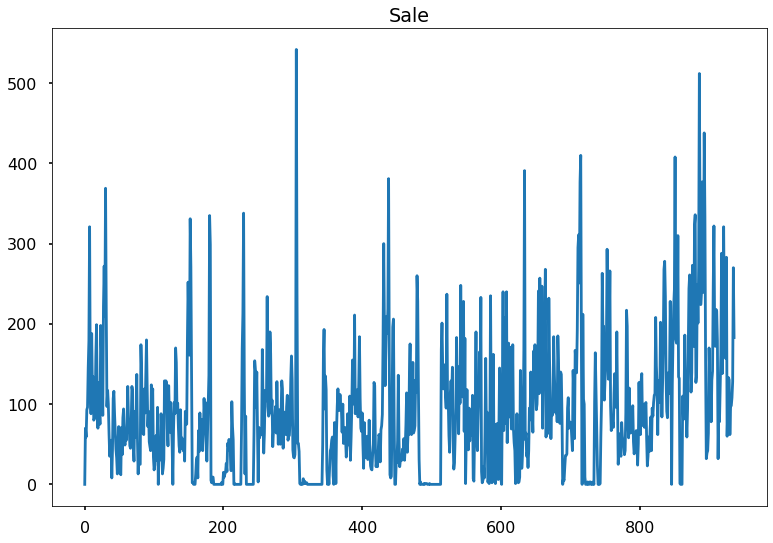

In [10]:
with plt.style.context("seaborn-poster"):
    fig, ax = plt.subplots()
    ax.set_title('Sale')
    retail["sale"].plot(ax=ax)
    plt.show()

In [11]:
retail['dow'] = retail['date'].dt.dayofweek
retail['day_of_week'] = retail['date'].dt.day_name()
#retail['weeknum'] = retail['date'].dt.week
retail['weeknum'] = retail['date'].dt.strftime('%W')

In [12]:
retail.head(20)

,date,sale,stock,price,dow,day_of_week,weeknum
0,2014-01-01,0,4972,1.29,2,Wednesday,00
1,2014-01-02,70,4902,1.29,3,Thursday,00
2,2014-01-03,59,4843,1.29,4,Friday,00
3,2014-01-04,93,4750,1.29,5,Saturday,00
4,2014-01-05,96,4654,1.29,6,Sunday,00
5,2014-01-06,145,4509,1.29,0,Monday,01
6,2014-01-07,179,4329,1.29,1,Tuesday,01
7,2014-01-08,321,4104,1.29,2,Wednesday,01
8,2014-01-09,125,4459,1.09,3,Thursday,01
9,2014-01-10,88,5043,1.09,4,Friday,01


### Day of Week Analysis

In [13]:
retail_dow = retail.groupby(['day_of_week','dow']).mean()

In [14]:
retail['sale']

0        0
1       70
2       59
3       93
4       96
      ... 
932     98
933    108
934    128
935    270
936    183
Name: sale, Length: 937, dtype: int64

In [15]:
retail_dow

,,sale,stock,price
day_of_week,dow,,,
Friday,4,89.373134,1690.268657,1.600373
Monday,0,69.212121,1535.143939,1.620985
Saturday,5,141.514925,1612.320896,1.581716
Sunday,6,96.866667,1535.970370,1.586074
Thursday,3,76.911111,1688.607407,1.577926
Tuesday,1,67.393939,1521.424242,1.601061
Wednesday,2,91.844444,1671.155556,1.580667


In [16]:
retail_dow.sort_values("dow", axis = 0, ascending = True, 
                 inplace = True, na_position ='last') 

In [17]:
retail_dow

,,sale,stock,price
day_of_week,dow,,,
Monday,0,69.212121,1535.143939,1.620985
Tuesday,1,67.393939,1521.424242,1.601061
Wednesday,2,91.844444,1671.155556,1.580667
Thursday,3,76.911111,1688.607407,1.577926
Friday,4,89.373134,1690.268657,1.600373
Saturday,5,141.514925,1612.320896,1.581716
Sunday,6,96.866667,1535.970370,1.586074


In [18]:
df = retail_dow.drop(['stock'], axis=1)

In [19]:
df

,,sale,price
day_of_week,dow,,
Monday,0,69.212121,1.620985
Tuesday,1,67.393939,1.601061
Wednesday,2,91.844444,1.580667
Thursday,3,76.911111,1.577926
Friday,4,89.373134,1.600373
Saturday,5,141.514925,1.581716
Sunday,6,96.866667,1.586074


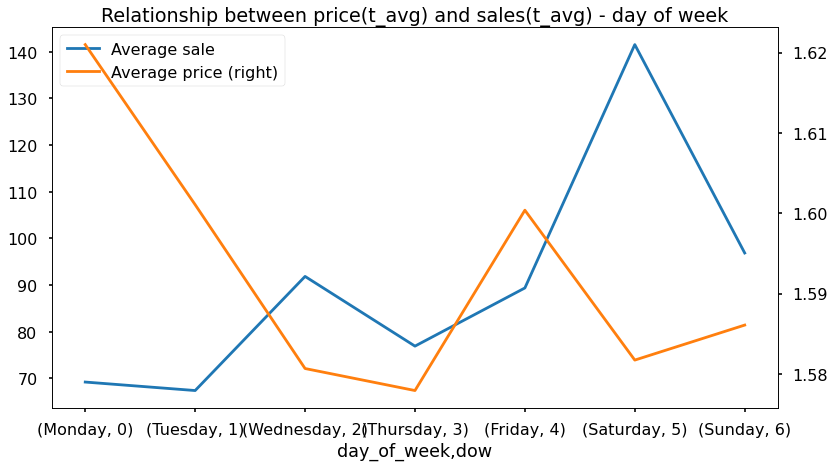

In [20]:
with plt.style.context('seaborn-poster'):
    df["sale"].plot(label="Average sale",  title = "Relationship between price(t_avg) and sales(t_avg) - day of week", legend=True, figsize=(13,7))
    df["price"].plot(label="Average price", legend=True, secondary_y=True)
    ## df.plot(figsize=(12,8),secondary_y=True)
    plt.show()

## According to above dual weekly graph, we could find there is an inverse relationship between sales and price

In [21]:
retail

,date,sale,stock,price,dow,day_of_week,weeknum
0,2014-01-01,0,4972,1.29,2,Wednesday,00
1,2014-01-02,70,4902,1.29,3,Thursday,00
2,2014-01-03,59,4843,1.29,4,Friday,00
3,2014-01-04,93,4750,1.29,5,Saturday,00
4,2014-01-05,96,4654,1.29,6,Sunday,00
...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,2,Wednesday,30
933,2016-07-28,108,3071,2.39,3,Thursday,30
934,2016-07-29,128,4095,2.39,4,Friday,30
935,2016-07-30,270,3825,2.39,5,Saturday,30


In [22]:
retail['year'] = retail['date'].dt.year

In [23]:
retail.head()

,date,sale,stock,price,dow,day_of_week,weeknum,year
0,2014-01-01,0,4972,1.29,2,Wednesday,00,2014
1,2014-01-02,70,4902,1.29,3,Thursday,00,2014
2,2014-01-03,59,4843,1.29,4,Friday,00,2014
3,2014-01-04,93,4750,1.29,5,Saturday,00,2014
4,2014-01-05,96,4654,1.29,6,Sunday,00,2014


In [24]:
retail_dow2 = retail.groupby(['year','weeknum']).mean()

In [25]:
retail_dow2

sale        stock     price       dow
year weeknum                                             
2014 00        63.600000  4824.200000  1.290000  4.000000
     01       166.714286  4685.857143  1.175714  3.000000
     02       124.666667  4694.500000  1.140000  2.833333
     03       119.714286  3842.714286  1.118571  3.000000
     04       214.285714  2688.857143  1.018571  3.000000
...                  ...          ...       ...       ...
2016 26       176.714286  1782.857143  2.390000  3.000000
     27       141.428571  1808.142857  2.390000  3.000000
     28       204.428571  1469.428571  1.961429  3.000000
     29       146.000000  1250.857143  2.175714  3.000000
     30       135.142857  3151.857143  2.390000  3.000000

[137 rows x 4 columns]

In [26]:
df2 = retail_dow2.drop(['stock','dow'], axis=1)

In [27]:
df2

sale     price
year weeknum                      
2014 00        63.600000  1.290000
     01       166.714286  1.175714
     02       124.666667  1.140000
     03       119.714286  1.118571
     04       214.285714  1.018571
...                  ...       ...
2016 26       176.714286  2.390000
     27       141.428571  2.390000
     28       204.428571  1.961429
     29       146.000000  2.175714
     30       135.142857  2.390000

[137 rows x 2 columns]

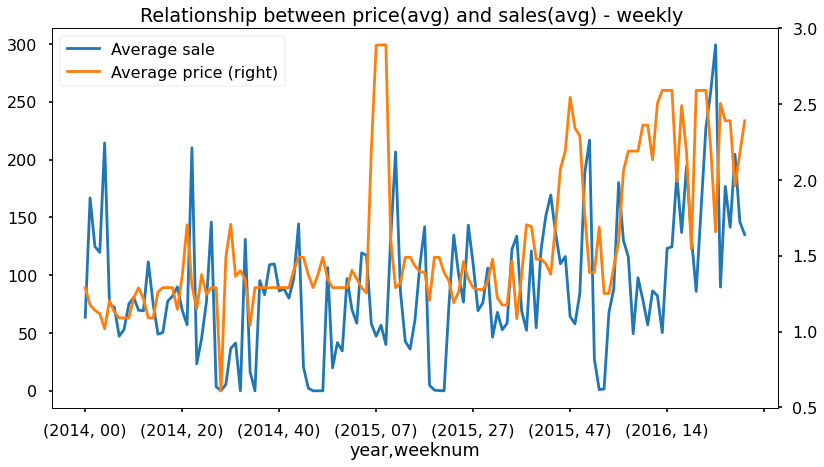

In [28]:
with plt.style.context('seaborn-poster'):
    df2["sale"].plot(label="Average sale",  title = "Relationship between price(avg) and sales(avg) - weekly ", legend=True, figsize=(13,7))
    df2["price"].plot(label="Average price", legend=True, secondary_y=True)
    ## df.plot(figsize=(12,8),secondary_y=True)
    plt.show()

<blank>

<blank>

<blank>

# 3. Moving Average

In [29]:
retail['7-day'] = retail['price'].rolling(7).mean()
retail['14-day'] = retail['price'].rolling(14).mean()
retail['21-day'] = retail['price'].rolling(21).mean()

In [30]:
retail

,date,sale,stock,price,dow,day_of_week,weeknum,year,7-day,14-day,21-day
0,2014-01-01,0,4972,1.29,2,Wednesday,00,2014,NaN,NaN,NaN
1,2014-01-02,70,4902,1.29,3,Thursday,00,2014,NaN,NaN,NaN
2,2014-01-03,59,4843,1.29,4,Friday,00,2014,NaN,NaN,NaN
3,2014-01-04,93,4750,1.29,5,Saturday,00,2014,NaN,NaN,NaN
4,2014-01-05,96,4654,1.29,6,Sunday,00,2014,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,2,Wednesday,30,2016,2.39,2.140000,2.175714
933,2016-07-28,108,3071,2.39,3,Thursday,30,2016,2.39,2.175714,2.175714
934,2016-07-29,128,4095,2.39,4,Friday,30,2016,2.39,2.211429,2.175714
935,2016-07-30,270,3825,2.39,5,Saturday,30,2016,2.39,2.247143,2.175714


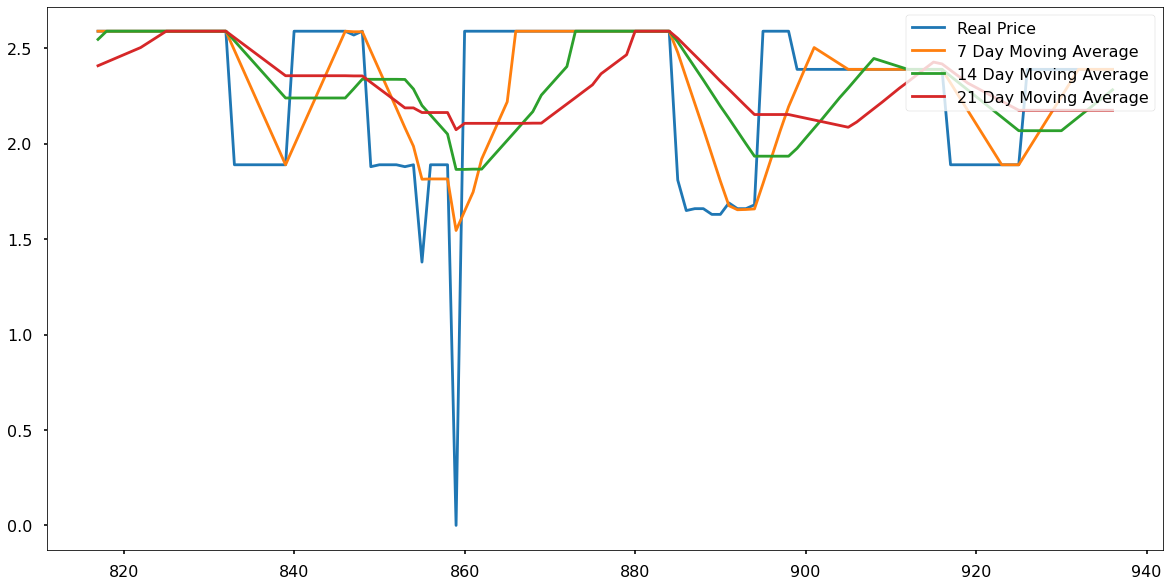

In [31]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize = (20,10))
    plt.plot(retail.price[-120:], label = 'Real Price')
    plt.plot(retail['7-day'][-120:], label = '7 Day Moving Average')
    plt.plot(retail['14-day'][-120:], label = '14 Day Moving Average')
    plt.plot(retail['21-day'][-120:], label = '21 Day Moving Average')
    plt.legend(loc =1)

In [32]:
retail['7-day'] = retail['sale'].rolling(7).mean()
retail['14-day'] = retail['sale'].rolling(14).mean()
retail['21-day'] = retail['sale'].rolling(21).mean()

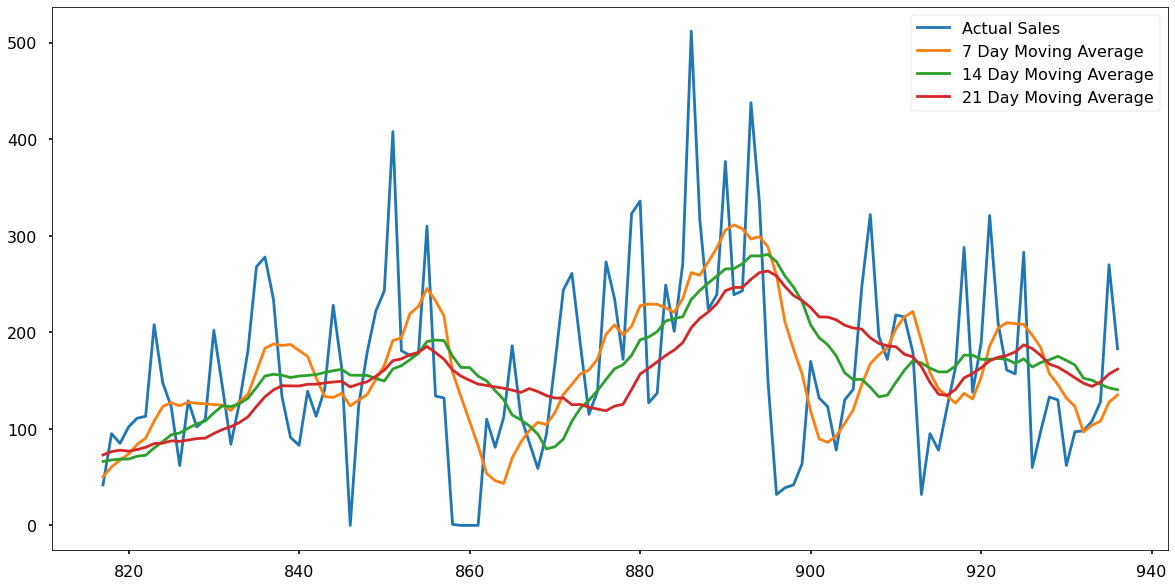

In [33]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize = (20,10))
    plt.plot(retail.sale[-120:], label = 'Actual Sales')
    plt.plot(retail['7-day'][-120:], label = '7 Day Moving Average')
    plt.plot(retail['14-day'][-120:], label = '14 Day Moving Average')
    plt.plot(retail['21-day'][-120:], label = '21 Day Moving Average')
    plt.legend(loc =1)

In [34]:
retail.head(20)

,date,sale,stock,price,dow,day_of_week,weeknum,year,7-day,14-day,21-day
0,2014-01-01,0,4972,1.29,2,Wednesday,00,2014,NaN,NaN,NaN
1,2014-01-02,70,4902,1.29,3,Thursday,00,2014,NaN,NaN,NaN
2,2014-01-03,59,4843,1.29,4,Friday,00,2014,NaN,NaN,NaN
3,2014-01-04,93,4750,1.29,5,Saturday,00,2014,NaN,NaN,NaN
4,2014-01-05,96,4654,1.29,6,Sunday,00,2014,NaN,NaN,NaN
5,2014-01-06,145,4509,1.29,0,Monday,01,2014,NaN,NaN,NaN
6,2014-01-07,179,4329,1.29,1,Tuesday,01,2014,91.714286,NaN,NaN
7,2014-01-08,321,4104,1.29,2,Wednesday,01,2014,137.571429,NaN,NaN
8,2014-01-09,125,4459,1.09,3,Thursday,01,2014,145.428571,NaN,NaN
9,2014-01-10,88,5043,1.09,4,Friday,01,2014,149.571429,NaN,NaN


## Seasonality


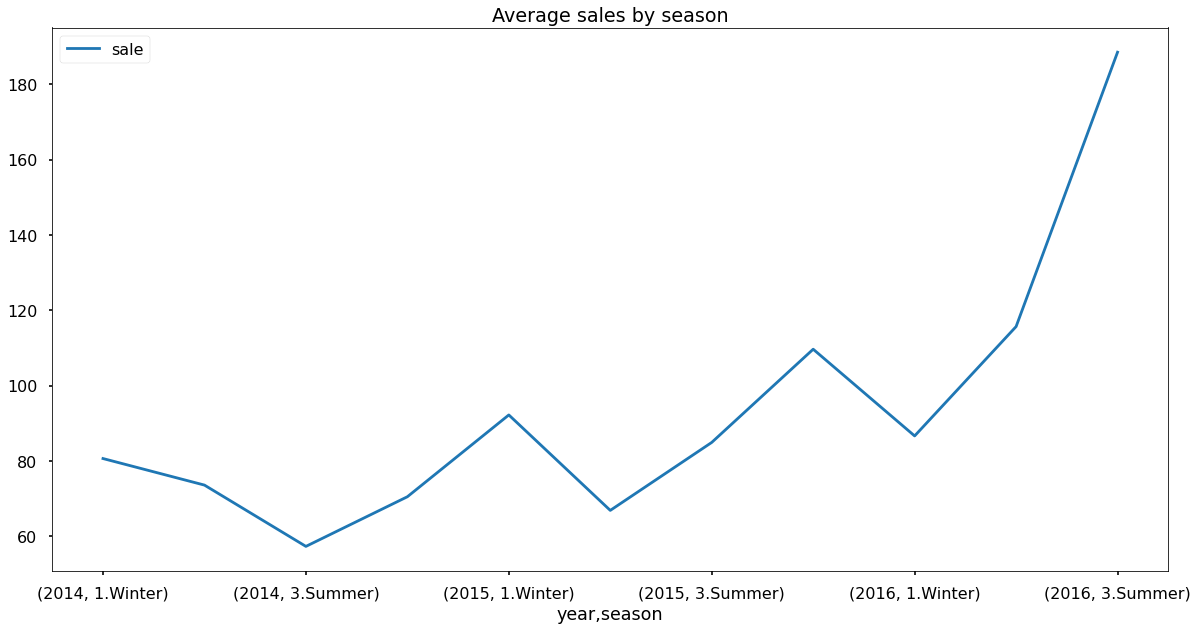

In [35]:
sn2str = {1: "1.Winter", 2: "2.Spring", 3: "3.Summer", 4: "4.Fall"}
retail["season"] = (retail["date"].dt.month % 12 // 3 + 1).map(sn2str)

gbseason = retail.loc[:, ["date", "sale", "year", "season"]].groupby(['year', 'season']).mean()
# print(gbseason)
with plt.style.context('seaborn-poster'):
    plt.figure(figsize = (20,10))
    gbseason.plot(ax = plt.gca(), title = "Average sales by season")
    # plt.legend(loc = 1)

## Dicky Fuller Test

#### Check for stationarity using the Dicky Fuller Test for all three datasets


In [36]:
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(retail['price'])
print(result1)

(-4.585437174184155, 0.00013739285676424415, 2, 934, {'1%': -3.4373707314972766, '5%': -2.8646394422797337, '10%': -2.5684203292233905}, -90.17618431524147)


<blank>

<blank>

<blank>

# 4.1 Simple Exponential Smoothing 

In [37]:
def simple_exp_smooth(d, extra_periods, alpha):

    d = np.array(d)  # Transform the input into a numpy array

    cols = len(d)  # Historical period length

    d = np.append(d, [np.nan] * extra_periods)  # Append np.nan into the demand array to cover future periods

    f = np.full(cols + extra_periods, np.nan)  # Forecast array

    f[0] = d[0]  # initialization of first forecast

    # Create all the t+1 forecasts until end of historical period

    for t in range(1, cols + 1):

        f[t] = alpha * d[t - 1] + (1 - alpha) * f[t - 1]
        f[cols + 1:] = f[t]  # Forecast for all extra periods

    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Error": f - d})
    return df


# 4.2 Double Exponential Smoothing

In [38]:
# Double Exponential Smoothing
def double_exp_smooth(d, extra_periods, alpha, beta):

    d = np.array(d)  # Transform the input into a numpy array
    cols = len(d)  # Historical period length
    d = np.append(d, [np.nan] * extra_periods)  # Append np.nan into the demand array to cover future periods
    # Creation of the level, trend, and forecast arrays
    f = np.full(cols + extra_periods, np.nan)  # Forecast array
    a = np.full(cols + extra_periods, np.nan)
    b = np.full(cols + extra_periods, np.nan)
    # Level and trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all the t+1 forecasts until end of historical period

    for t in range(1, cols):
        f[t] = a[t - 1] + b[t - 1]
        a[t] = alpha * d[t] + (1 - alpha) * (a[t - 1] + b[t - 1])
        b[t] = beta * (a[t] - a[t - 1]) + (1 - beta) * b[t - 1]


# Forecast for all extra periods
    for t in range(cols, cols + extra_periods):
        f[t] = a[t - 1] + b[t - 1]
        a[t] = f[t]
        b[t] = b[t - 1]

    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Level": a, "Trend": b, "Error": f - d})
    return df

In [39]:
df1=simple_exp_smooth(retail['sale'], 14, 0.15)
df1.head(10)

,Demand,Forecast,Error
0,0.0,0.000000,0.000000
1,70.0,0.000000,-70.000000
2,59.0,10.500000,-48.500000
3,93.0,17.775000,-75.225000
4,96.0,29.058750,-66.941250
5,145.0,39.099937,-105.900063
6,179.0,54.984947,-124.015053
7,321.0,73.587205,-247.412795
8,125.0,110.699124,-14.300876
9,88.0,112.844255,24.844255


In [40]:
# For KPI Calculation
MAE = df1["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df1["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 49.55
RMSE: 69.51


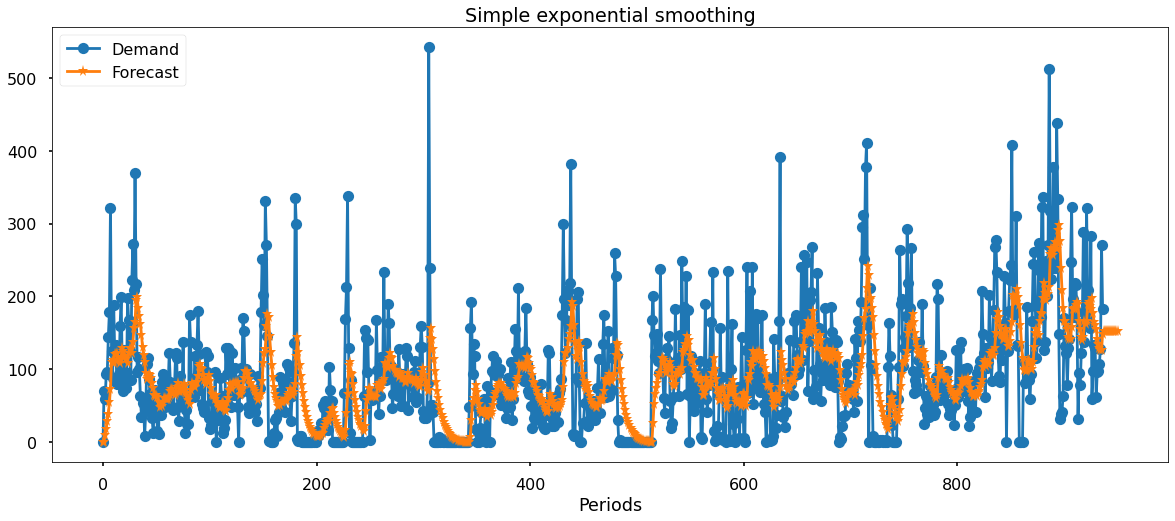

In [41]:
#For Plotting
with plt.style.context('seaborn-poster'):
    df1.index.name = "Periods"
    df1[["Demand","Forecast"]].plot(figsize=(20,8),title="Simple exponential smoothing",style=["-o","-*"])  
    plt.show()


In [42]:
df11=double_exp_smooth(retail['sale'],14,0.2,0.1)
df11.head(10)

,Demand,Forecast,Level,Trend,Error
0,0.0,NaN,0.000000,70.000000,NaN
1,70.0,70.000000,70.000000,70.000000,0.000000
2,59.0,140.000000,123.800000,68.380000,81.000000
3,93.0,192.180000,172.344000,66.396400,99.180000
4,96.0,238.740400,210.192320,63.541592,142.740400
5,145.0,273.733912,247.987130,60.966914,128.733912
6,179.0,308.954043,282.963235,58.367833,129.954043
7,321.0,341.331068,337.264854,57.961212,20.331068
8,125.0,395.226066,341.180852,52.556690,270.226066
9,88.0,393.737543,332.590034,46.441939,305.737543


In [43]:
MAE = df11["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df11["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 53.98
RMSE: 76.49


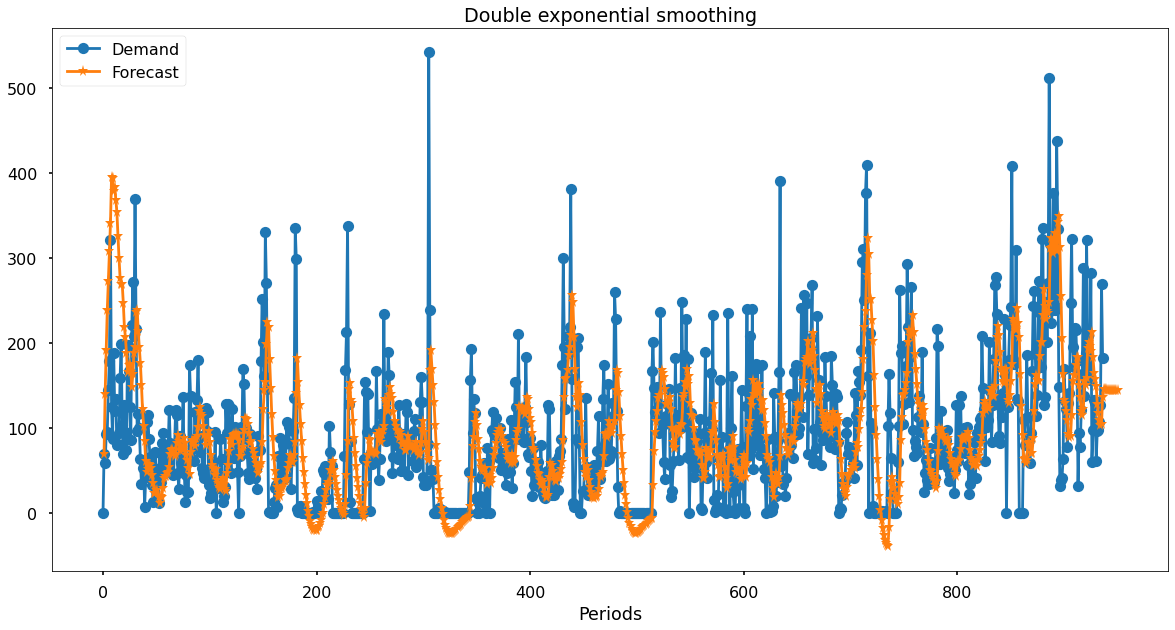

In [44]:
#For Plotting
with plt.style.context('seaborn-poster'):
    df11.index.name = "Periods"
    df11[["Demand","Forecast"]].plot(figsize=(20,10),title="Double exponential smoothing",style=["-o","-*"])  
    plt.show()

<blank>

<blank>
<blank>
<blank>

# 5. Machine Learning

In [45]:
retail

,date,sale,stock,price,dow,day_of_week,weeknum,year,7-day,14-day,21-day,season
0,2014-01-01,0,4972,1.29,2,Wednesday,00,2014,NaN,NaN,NaN,1.Winter
1,2014-01-02,70,4902,1.29,3,Thursday,00,2014,NaN,NaN,NaN,1.Winter
2,2014-01-03,59,4843,1.29,4,Friday,00,2014,NaN,NaN,NaN,1.Winter
3,2014-01-04,93,4750,1.29,5,Saturday,00,2014,NaN,NaN,NaN,1.Winter
4,2014-01-05,96,4654,1.29,6,Sunday,00,2014,NaN,NaN,NaN,1.Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,2,Wednesday,30,2016,96.857143,152.571429,147.333333,3.Summer
933,2016-07-28,108,3071,2.39,3,Thursday,30,2016,103.714286,150.428571,143.952381,3.Summer
934,2016-07-29,128,4095,2.39,4,Friday,30,2016,108.000000,146.071429,148.523810,3.Summer
935,2016-07-30,270,3825,2.39,5,Saturday,30,2016,127.571429,142.428571,156.857143,3.Summer


Predict based on weekly average

In [46]:
retail["year_week"] = retail["year"].map(str) + '-' + retail["weeknum"].map(str)

In [47]:
retail

,date,sale,stock,price,dow,day_of_week,weeknum,year,7-day,14-day,21-day,season,year_week
0,2014-01-01,0,4972,1.29,2,Wednesday,00,2014,NaN,NaN,NaN,1.Winter,2014-00
1,2014-01-02,70,4902,1.29,3,Thursday,00,2014,NaN,NaN,NaN,1.Winter,2014-00
2,2014-01-03,59,4843,1.29,4,Friday,00,2014,NaN,NaN,NaN,1.Winter,2014-00
3,2014-01-04,93,4750,1.29,5,Saturday,00,2014,NaN,NaN,NaN,1.Winter,2014-00
4,2014-01-05,96,4654,1.29,6,Sunday,00,2014,NaN,NaN,NaN,1.Winter,2014-00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,2,Wednesday,30,2016,96.857143,152.571429,147.333333,3.Summer,2016-30
933,2016-07-28,108,3071,2.39,3,Thursday,30,2016,103.714286,150.428571,143.952381,3.Summer,2016-30
934,2016-07-29,128,4095,2.39,4,Friday,30,2016,108.000000,146.071429,148.523810,3.Summer,2016-30
935,2016-07-30,270,3825,2.39,5,Saturday,30,2016,127.571429,142.428571,156.857143,3.Summer,2016-30


In [48]:
retail_ml = retail.groupby(["year_week"]).mean()

In [49]:
retail_ml

,sale,stock,price,dow,year,7-day,14-day,21-day
year_week,,,,,,,,
2014-00,63.600000,4824.200000,1.290000,4.000000,2014.0,NaN,NaN,NaN
2014-01,166.714286,4685.857143,1.175714,3.000000,2014.0,142.357143,NaN,NaN
2014-02,124.666667,4694.500000,1.140000,2.833333,2014.0,132.023810,131.442857,NaN
2014-03,119.714286,3842.714286,1.118571,3.000000,2014.0,119.612245,128.295918,127.828571
2014-04,214.285714,2688.857143,1.018571,3.000000,2014.0,164.918367,142.265306,140.503401
...,...,...,...,...,...,...,...,...
2016-26,176.714286,1782.857143,2.390000,3.000000,2016.0,127.714286,157.102041,203.823129
2016-27,141.428571,1808.142857,2.390000,3.000000,2016.0,187.897959,157.806122,167.367347
2016-28,204.428571,1469.428571,1.961429,3.000000,2016.0,153.183673,170.540816,156.265306


In [50]:
retail_ml = retail_ml.drop(['stock','year','7-day','14-day','21-day','dow','price'], axis=1)

In [51]:
retail_ml.sort_values("year_week", axis = 0, ascending = True, 
                 inplace = True, na_position ='last') 


In [52]:
retail_ml

,sale
year_week,
2014-00,63.600000
2014-01,166.714286
2014-02,124.666667
2014-03,119.714286
2014-04,214.285714
...,...
2016-26,176.714286
2016-27,141.428571
2016-28,204.428571


In [53]:
df_ml = pd.DataFrame(retail_ml)

In [54]:
df_ml

,sale
year_week,
2014-00,63.600000
2014-01,166.714286
2014-02,124.666667
2014-03,119.714286
2014-04,214.285714
...,...
2016-26,176.714286
2016-27,141.428571
2016-28,204.428571


In [55]:
df_ml = df_ml.sort_values(by = ['year_week'], ascending = [True])
retail_ml = retail_ml.sort_values(by = ['year_week'], ascending = [True])

In [56]:
# Create 53 weeks of lag values to predict current observation
# Shift of 53 weeks in this case
for i in range(53,0,-1):
    df_ml[['t-'+str(i)]] = retail_ml.shift(i)
print(df_ml)

                 sale        t-53        t-52        t-51        t-50  \
year_week                                                               
2014-00     63.600000         NaN         NaN         NaN         NaN   
2014-01    166.714286         NaN         NaN         NaN         NaN   
2014-02    124.666667         NaN         NaN         NaN         NaN   
2014-03    119.714286         NaN         NaN         NaN         NaN   
2014-04    214.285714         NaN         NaN         NaN         NaN   
...               ...         ...         ...         ...         ...   
2016-26    176.714286  143.285714  109.714286   69.285714   76.142857   
2016-27    141.428571  109.714286   69.285714   76.142857  106.142857   
2016-28    204.428571   69.285714   76.142857  106.142857   46.285714   
2016-29    146.000000   76.142857  106.142857   46.285714   67.857143   
2016-30    135.142857  106.142857   46.285714   67.857143   52.857143   

                 t-49        t-48        t-47     

In [57]:
df_ml

,sale,t-53,t-52,t-51,t-50,t-49,t-48,t-47,t-46,t-45,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
year_week,,,,,,,,,,,,,,,,,,,,,
2014-00,63.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01,166.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.600000
2014-02,124.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.600000,166.714286
2014-03,119.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.600000,166.714286,124.666667
2014-04,214.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.600000,166.714286,124.666667,119.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-26,176.714286,143.285714,109.714286,69.285714,76.142857,106.142857,46.285714,67.857143,52.857143,58.285714,...,186.428571,136.857143,194.142857,133.000000,86.000000,156.857143,227.571429,259.142857,299.142857,89.714286
2016-27,141.428571,109.714286,69.285714,76.142857,106.142857,46.285714,67.857143,52.857143,58.285714,122.428571,...,136.857143,194.142857,133.000000,86.000000,156.857143,227.571429,259.142857,299.142857,89.714286,176.714286
2016-28,204.428571,69.285714,76.142857,106.142857,46.285714,67.857143,52.857143,58.285714,122.428571,133.714286,...,194.142857,133.000000,86.000000,156.857143,227.571429,259.142857,299.142857,89.714286,176.714286,141.428571


In [58]:
retail.describe()

,sale,stock,price,dow,year,7-day,14-day,21-day
count,937.000000,937.000000,937.000000,937.000000,937.000000,931.000000,924.000000,917.000000
mean,90.533618,1608.258271,1.592572,3.012807,2014.844184,90.383766,90.069728,89.631874
std,80.682089,1356.691877,0.529502,1.997821,0.766033,58.217363,49.885543,44.837099
min,0.000000,0.000000,0.000000,0.000000,2014.000000,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000,1.000000,2014.000000,53.642857,61.142857,62.238095
50%,76.000000,1348.000000,1.390000,3.000000,2015.000000,82.428571,82.642857,82.523810
75%,127.000000,1964.000000,1.890000,5.000000,2015.000000,121.857143,117.910714,111.666667
max,542.000000,7228.000000,2.980000,6.000000,2016.000000,311.285714,280.714286,263.571429


In [59]:
retail.to_csv('output.csv')

In [60]:
# df_ml = df_ml.drop(['sale'], axis=1)

In [61]:
df_ml

,sale,t-53,t-52,t-51,t-50,t-49,t-48,t-47,t-46,t-45,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
year_week,,,,,,,,,,,,,,,,,,,,,
2014-00,63.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01,166.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.600000
2014-02,124.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.600000,166.714286
2014-03,119.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.600000,166.714286,124.666667
2014-04,214.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.600000,166.714286,124.666667,119.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-26,176.714286,143.285714,109.714286,69.285714,76.142857,106.142857,46.285714,67.857143,52.857143,58.285714,...,186.428571,136.857143,194.142857,133.000000,86.000000,156.857143,227.571429,259.142857,299.142857,89.714286
2016-27,141.428571,109.714286,69.285714,76.142857,106.142857,46.285714,67.857143,52.857143,58.285714,122.428571,...,136.857143,194.142857,133.000000,86.000000,156.857143,227.571429,259.142857,299.142857,89.714286,176.714286
2016-28,204.428571,69.285714,76.142857,106.142857,46.285714,67.857143,52.857143,58.285714,122.428571,133.714286,...,194.142857,133.000000,86.000000,156.857143,227.571429,259.142857,299.142857,89.714286,176.714286,141.428571


In [62]:
# 52 weeks of lag values to predict current observation
X = df_ml[53:].values[:, 1:]
y = df_ml[53:].values[:, 0]

In [63]:
# 12 weeks ~= a quarter
Xq = df_ml[12:].values[:, 1+(53-12):]
yq = df_ml[12:].values[:, 0]

In [64]:
# 3 weeks lag ~= a month
Xm = df_ml[3:].values[:, 1+(53-3):]
ym = df_ml[3:].values[:, 0]

In [65]:
# Column t, which is the original time series
# Give first 10 values of target variable, time series
print(X.shape, Xq.shape, Xm.shape)

(84, 53) (125, 12) (134, 3)


# We are using 80-20 and 70-30 split.

In [66]:

def naive_split(X, y, split_percentage=.8):
    """
    Split data into training and test sets
    """
    # Split data into training and test sets
    split_index = int(len(X) * split_percentage)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test


def split_sequence(seq, n_steps):
    X, y = list(), list()
    for i in range(len(seq)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(seq) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = seq[i:end_ix], seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


datasets = {
    # "naive_53_0.7": (naive_split(X, y, split_percentage=.7)),
    # "naive_12_0.7": (naive_split(Xq, yq, split_percentage=.7)),
    # "naive_3_0.7": (naive_split(Xm, ym, split_percentage=.7)),
    # "naive_53_0.8": (naive_split(X, y, split_percentage=.8)),
    # "naive_12_0.8": (naive_split(Xq, yq, split_percentage=.8)),
    # "naive_3_0.8": (naive_split(Xm, ym, split_percentage=.8)),
    # "naive_53_0.9": (naive_split(X, y, split_percentage=.9)),
    # "naive_12_0.9": (naive_split(Xq, yq, split_percentage=.9)),
    # "naive_3_0.9": (naive_split(Xm, ym, split_percentage=.9)),
    "sequence_53_0.9": (naive_split(*split_sequence(df_ml["sale"].values, 53), split_percentage=.9)),
    "sequence_53_0.8": (naive_split(*split_sequence(df_ml["sale"].values, 53), split_percentage=.8)),
    "sequence_53_0.7": (naive_split(*split_sequence(df_ml["sale"].values, 53), split_percentage=.7)),
    "sequence_12_0.9": (naive_split(*split_sequence(df_ml["sale"].values, 12), split_percentage=.9)),
    "sequence_12_0.8": (naive_split(*split_sequence(df_ml["sale"].values, 12), split_percentage=.8)),
    "sequence_12_0.7": (naive_split(*split_sequence(df_ml["sale"].values, 12), split_percentage=.7)),
    "sequence_3_0.9": (naive_split(*split_sequence(df_ml["sale"].values, 3), split_percentage=.9)),
    "sequence_3_0.8": (naive_split(*split_sequence(df_ml["sale"].values, 3), split_percentage=.8)),
    "sequence_3_0.7": (naive_split(*split_sequence(df_ml["sale"].values, 3), split_percentage=.7)),
}

for k,(X_train, X_test, y_train, y_test) in datasets.items():
    print(k, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# assert np.array_equal(datasets['naive_3_0.7'][3],datasets['sequence_3_0.7'][3])




sequence_53_0.9 (75, 53) (9, 53) (75,) (9,)
sequence_53_0.8 (67, 53) (17, 53) (67,) (17,)
sequence_53_0.7 (58, 53) (26, 53) (58,) (26,)
sequence_12_0.9 (112, 12) (13, 12) (112,) (13,)
sequence_12_0.8 (100, 12) (25, 12) (100,) (25,)
sequence_12_0.7 (87, 12) (38, 12) (87,) (38,)
sequence_3_0.9 (120, 3) (14, 3) (120,) (14,)
sequence_3_0.8 (107, 3) (27, 3) (107,) (27,)
sequence_3_0.7 (93, 3) (41, 3) (93,) (41,)


## Benchmark Model

In [67]:
def benchmark_model(model, X_train, X_test, y_train, y_test, seed=124):
    np.random.seed(seed)
    
    model.fit(X_train, y_train)
    r2text = fr"Training $R^2$: {model.score(X_train, y_train):.2f}"
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    maetext, rmsetext = fr"MAE (test): {mae:.4f}", fr"RMSE (test): {rmse:.4f}"
    
    textstr = "\n".join((r2text, maetext, rmsetext))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    Xpreds = model.predict(X_train)

    # Scatter the predictions vs actual values, orange is predicted
    with plt.style.context("seaborn-poster"):
        fig, (ax1, ax2) = plt.subplots(2, 1)
        fig.tight_layout()
        ax1.scatter(y_train, Xpreds, label='Actual vs Predictions in Train')  # blue 
        ax1.scatter(y_test, preds, label='Actual vs Predictions in Test')  # orange
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
        ax1.legend(loc=1)
        ax2.hist(Xpreds - y_train, bins=20, label='Prediction Error in Train')
        ax2.hist(preds - y_test, bins=20, label='Prediction Error in Test')
        ax2.legend(loc=1)
        ax2.set_title("Histogram of Predictions - Actual")
        plt.show()
    return mae

def plot_preds_true_1d(model, X, y, title):
    preds = model.predict(X)
    x_axis = np.arange(0, len(y), 1)
    if np.ndim(y) > 1:
        for l in range(np.ndim(y) - 1):
            y = np.squeeze(y)
    if np.ndim(preds) > 1:
        for l in range(np.ndim(preds) - 1):
            preds = np.squeeze(preds)
    with plt.style.context("seaborn-poster"):
        plt.figure(figsize=(15, 3))
        plt.plot(x_axis, y, color='blue', label='True')
        plt.plot(x_axis, preds, color='red', label='Predicted')
        plt.title(title)
        plt.legend()
        plt.show()

## Linear Regression

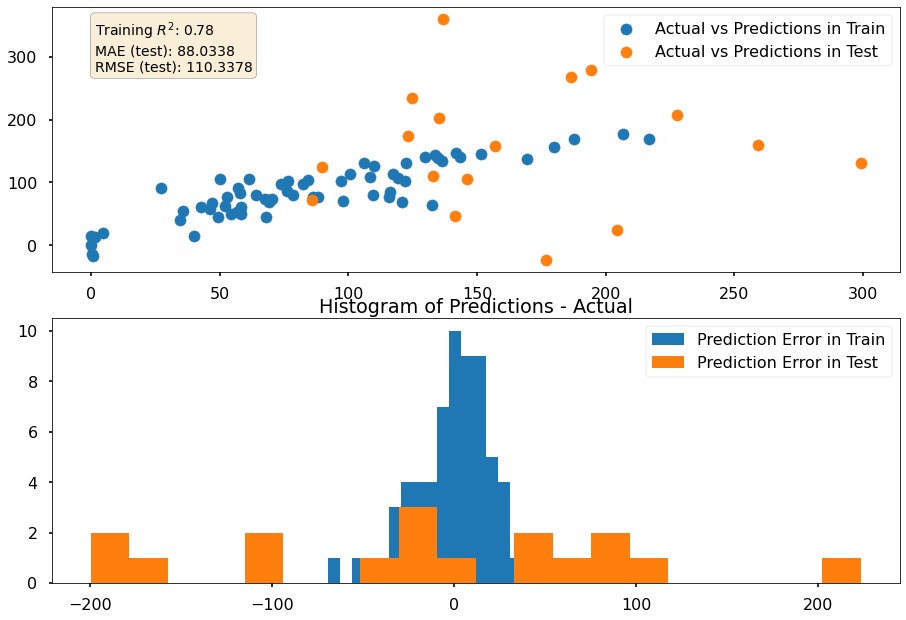

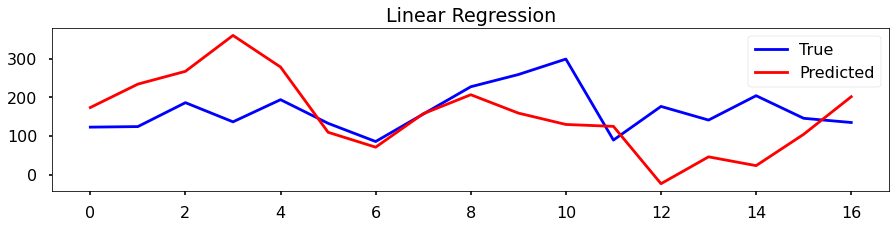

In [68]:
from sklearn.linear_model import LinearRegression
  
reg = LinearRegression() # Create a linear regression object

benchmark_model(reg, *datasets["sequence_53_0.8"])
plot_preds_true_1d(reg, datasets['sequence_53_0.8'][1], datasets['sequence_53_0.8'][3], "Linear Regression")

## Decision Tree Model

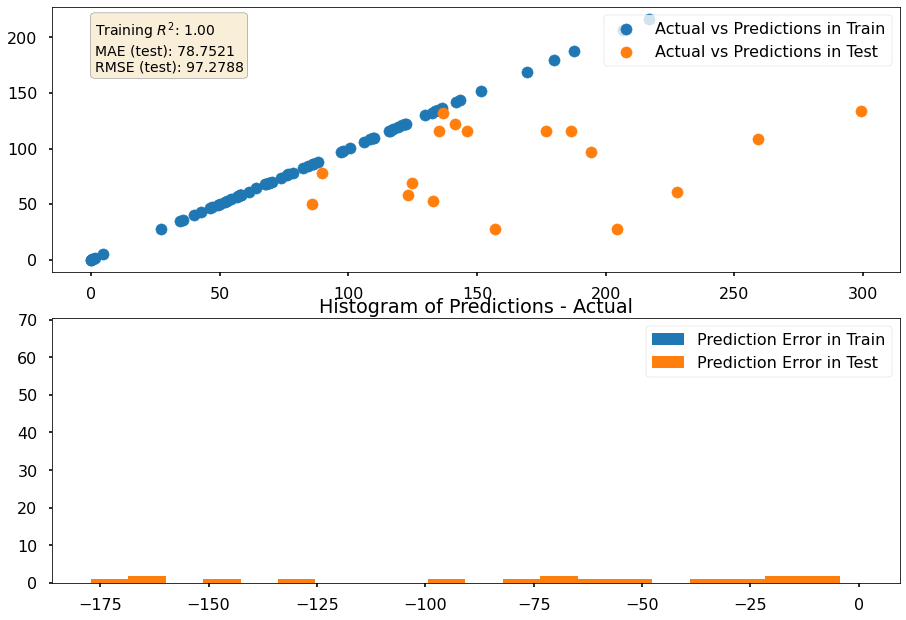

78.75210084033613

In [69]:
# Decision Tree Regression Model

from sklearn.tree import DecisionTreeRegressor

dtreg = DecisionTreeRegressor(criterion='absolute_error')  # max_depth not set


benchmark_model(dtreg, *datasets["sequence_53_0.8"])

In [70]:
# Find Best Max Depth
def find_max_depth(model, X_train, X_test, y_train, y_test, max_depth=10,
                   seed=124):
    np.random.seed(seed)
    depths = np.arange(1, max_depth + 1)
    train_scores = []
    test_scores = []
    for d in depths:
        model.set_params(max_depth=d)
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))

    return depths, train_scores, test_scores

def parse_model_desc(model_desc):
    model_desc = model_desc.split("_")
    model_type = model_desc[0]
    n_feature = int(model_desc[1])
    train_size = float(model_desc[2])
    return model_type, n_feature, train_size

key = "sequence_53_0.8"
d, trs, tes = find_max_depth(dtreg, *datasets[key])
print(f"Max Depth for {parse_model_desc(key)} (shape: {datasets[key][0].shape}) is {d[np.argmax(tes)]}")


Max Depth for ('sequence', 53, 0.8) (shape: (67, 53)) is 9


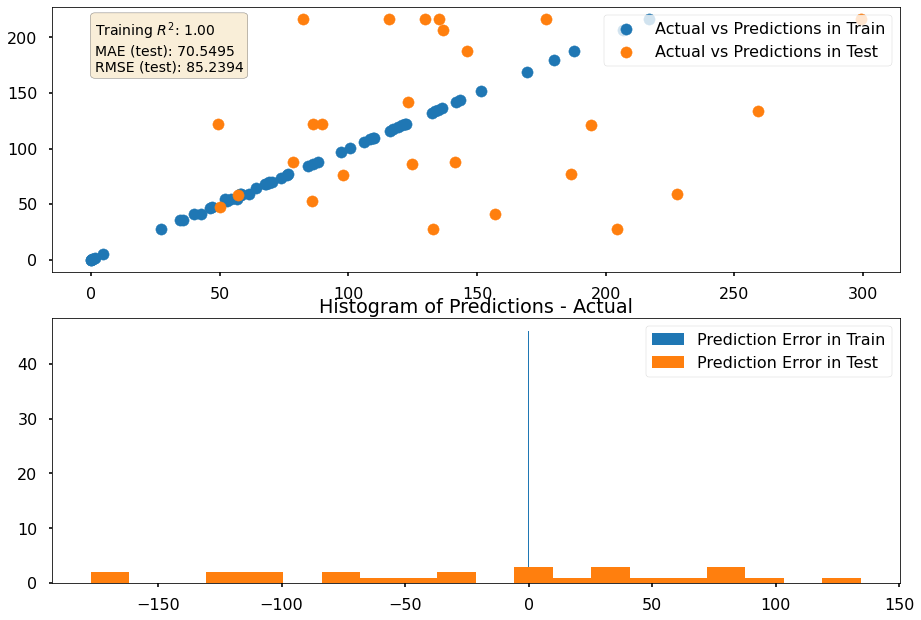

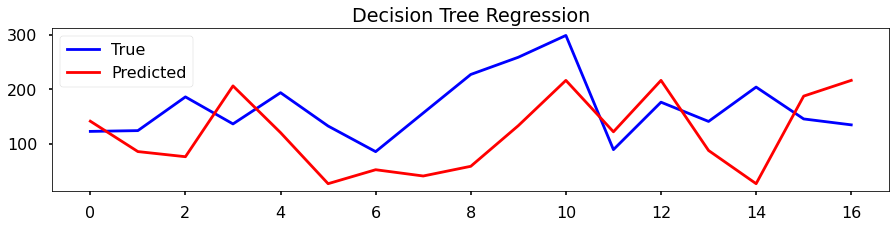

In [71]:
# Plot predicted against actual values

from matplotlib import pyplot as plt

# Use the best max_depth 
decision_tree_retail = DecisionTreeRegressor(max_depth=9) # Fill in best max depth score here

benchmark_model(decision_tree_retail, *datasets["sequence_53_0.7"])
plot_preds_true_1d(decision_tree_retail, datasets['sequence_53_0.8'][1], datasets['sequence_53_0.8'][3], "Decision Tree Regression")

<blank>

<blank>

## Random Forest Model

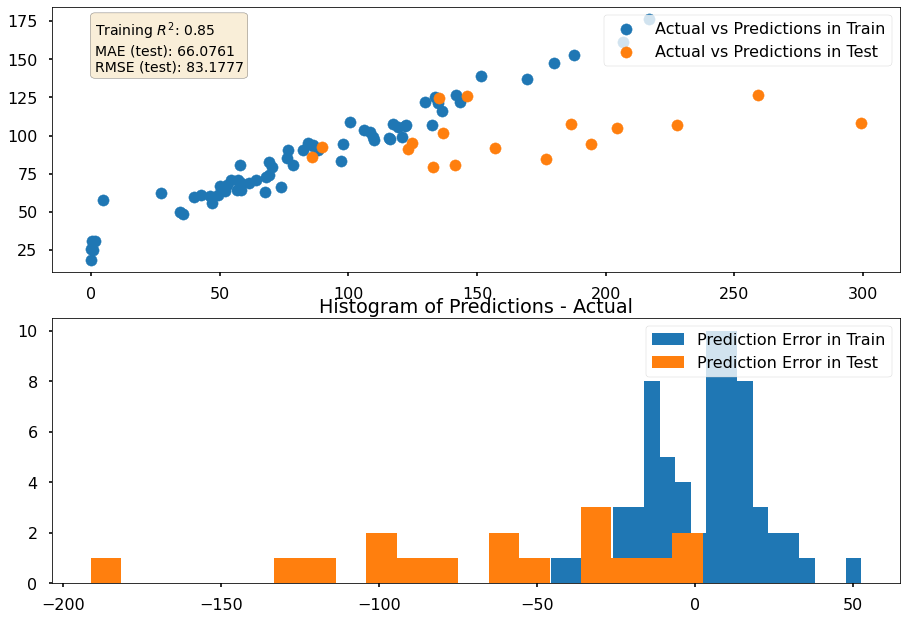

66.07613445378155

In [72]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)

# # Look at the R^2 scores on train and test
benchmark_model(rfr, *datasets['sequence_53_0.8'])

In [73]:
def grid_search(grid, model, X_train, X_test, y_train, y_test, seed=124):
    from sklearn.model_selection import ParameterGrid
    train_scores = []
    test_scores = []
    for params in ParameterGrid(grid):
        np.random.seed(seed)
        model.set_params(**params)
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))
    return train_scores, test_scores

def best_params(grid, scores):
    from sklearn.model_selection import ParameterGrid

    return ParameterGrid(grid)[np.argmax(scores)]

rf_grid = {
    'n_estimators': [200],
    'max_depth': list(range(2, 11)),
    'max_features': list(range(3, parse_model_desc(key)[1] + 1, 2)),
}
# uncomment to run the grid search
# _, tes = grid_search(rf_grid, rfr, *datasets[key])
# print(f"Best params for {parse_model_desc(key)} (shape: {datasets[key][0].shape}) is {best_params(rf_grid, tes)}")

### We use max_depth : 10

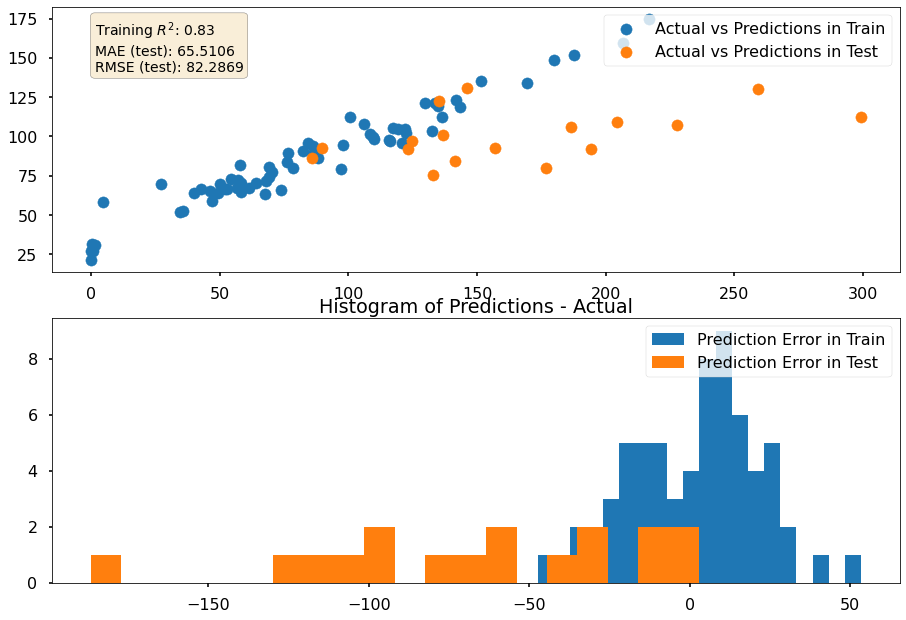

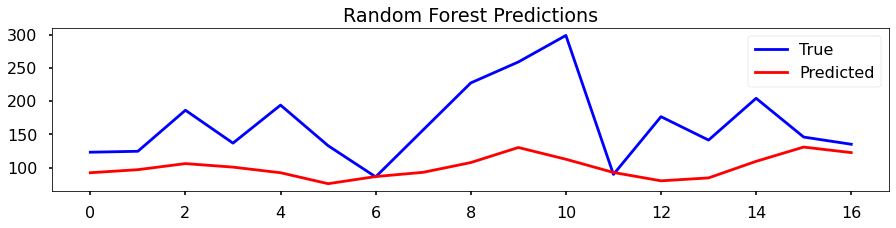

In [74]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=5, max_features = 51)

benchmark_model(rfr, *datasets['sequence_53_0.8'])
plot_preds_true_1d(rfr, datasets['sequence_53_0.8'][1], datasets['sequence_53_0.8'][3], "Random Forest Predictions")

In [75]:
# Random Forest Feature Importance
# get column names
df_ml.columns

Index(['sale', 't-53', 't-52', 't-51', 't-50', 't-49', 't-48', 't-47', 't-46',
       't-45', 't-44', 't-43', 't-42', 't-41', 't-40', 't-39', 't-38', 't-37',
       't-36', 't-35', 't-34', 't-33', 't-32', 't-31', 't-30', 't-29', 't-28',
       't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20', 't-19',
       't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10',
       't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1'],
      dtype='object')

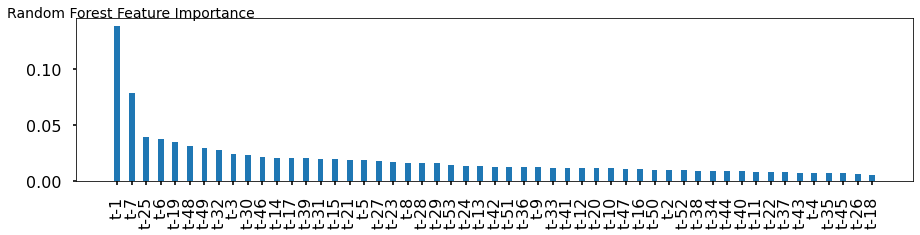

In [76]:

with plt.style.context("seaborn-poster"):
    # Get feature importances from our random forest model
    importances = rfr.feature_importances_

    # Get the index of importances from greatest importance to least
    sorted_index = np.argsort(importances)[::-1]
    x = range(len(importances))
    # Create tick labels 
    feature_names = ['t-53','t-52','t-51','t-50','t-49','t-48','t-47','t-46','t-45','t-44','t-43','t-42','t-41','t-40','t-39','t-38','t-37','t-36','t-35','t-34','t-33','t-32','t-31','t-30','t-29','t-28','t-27','t-26','t-25','t-24','t-23','t-22','t-21','t-20','t-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1']
    labels = np.array(feature_names)[sorted_index]
    plt.figure(figsize=(15, 3))
    plt.bar(x, importances[sorted_index], tick_label=labels, width = 0.4)

    plt.text(0.95, 0.15, 'Random Forest Feature Importance', ha='center', va='center', fontsize=14)

    # Rotate tick labels to vertical
    plt.xticks(rotation=90)
    plt.show()

# 5.4 GBDT


In [77]:
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

gbr_params = {
    "max_depth": [25 -1],
    "learning_rate": [0.0005, 0.001],
    "n_estimators": [2000],
}
gbr_m = GradientBoostingRegressor()
_, gbr_tes = grid_search(gbr_params, gbr_m, *datasets[key])
print(f"Best params for {parse_model_desc(key)} (shape: {datasets[key][0].shape}) is {best_params(gbr_params, gbr_tes)}")
gbdt_params = {
    "max_depth": [25 -1],
    "learning_rate": [0.0005, 0.001],
    "n_estimators": [2000],
}
_, gbdt_tes = grid_search(gbdt_params, LGBMRegressor(), *datasets[key])
print(f"Best params for {parse_model_desc(key)} (shape: {datasets[key][0].shape}) is {best_params(gbdt_params, gbdt_tes)}")

Best params for ('sequence', 53, 0.8) (shape: (67, 53)) is {'n_estimators': 2000, 'max_depth': 24, 'learning_rate': 0.001}
Best params for ('sequence', 53, 0.8) (shape: (67, 53)) is {'n_estimators': 2000, 'max_depth': 24, 'learning_rate': 0.0005}


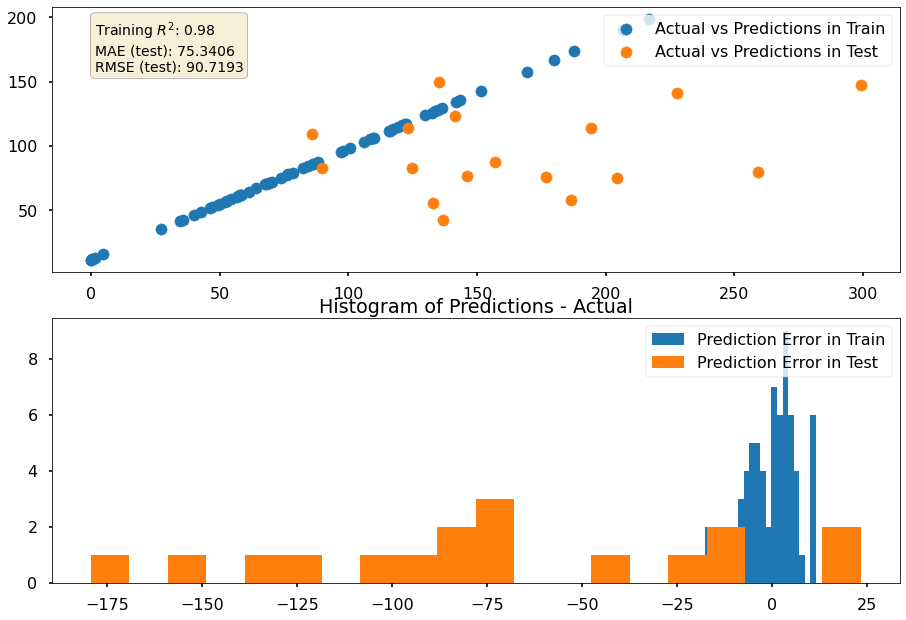

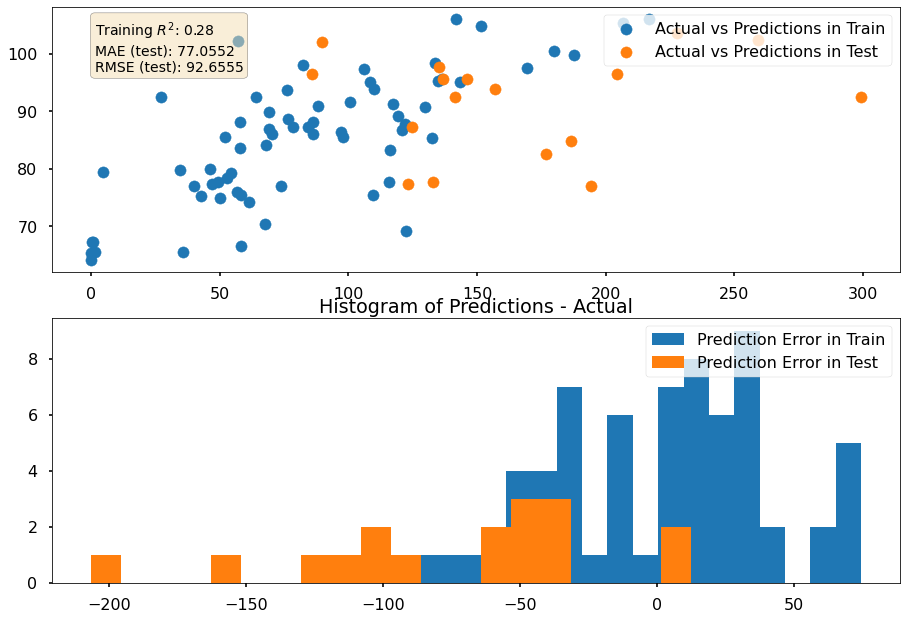

77.05519793551417

In [78]:
# sklearn gbr best params was n_estimators=2000, max_depth=25, learning_rate=0.001
gbr = GradientBoostingRegressor(n_estimators=2000, max_depth=25, learning_rate=0.001)
# lightgbm gbmr best params was n_estimators=2000, max_depth=25, learning_rate=0.0005
gbmr = LGBMRegressor(n_estimators=2000, max_depth=25, learning_rate=0.0005)

benchmark_model(gbr, *datasets['sequence_53_0.8'])
benchmark_model(gbmr, *datasets['sequence_53_0.8'])


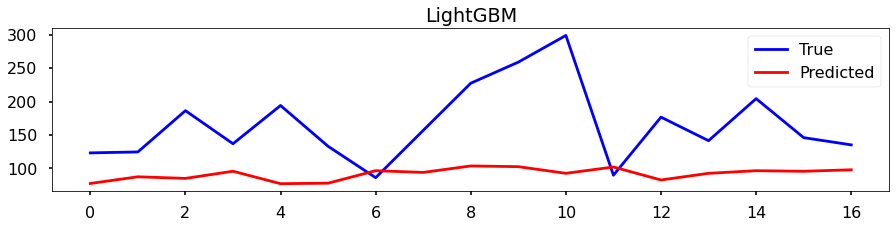

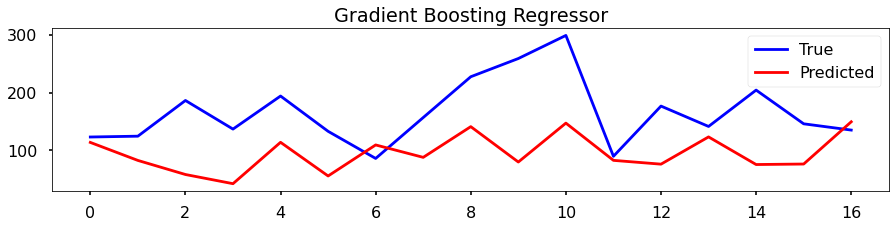

In [79]:

_, _X, _, _y = datasets['sequence_53_0.8']
plot_preds_true_1d(gbmr, _X, _y, "LightGBM")
plot_preds_true_1d(gbr, _X, _y, "Gradient Boosting Regressor")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-01-22 00:10:54.465743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-22 00:10:54.465859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-22 00:10:54.551839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 00:10:54.551962: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20
  1/906 [..............................] - ETA: 5:59 - loss: 0.0206

2022-01-22 00:10:54.792004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


906/906 [==============================] - 8s 8ms/step - loss: 0.0163 - val_loss: 0.0179


2022-01-22 00:11:02.441551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-22 00:11:02.607037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


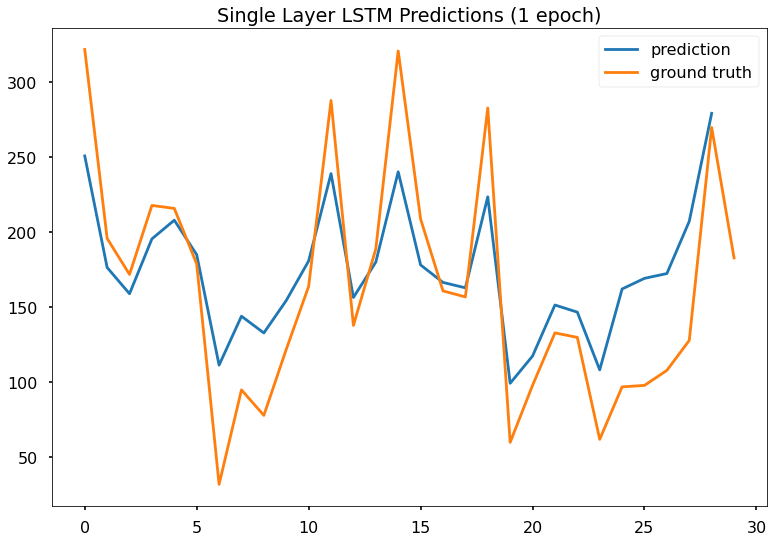

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../dataset/mock_retail_sales.csv.zip', index_col="data")
df = df.rename(columns={'data' : 'Date', 'venda' : 'Sales', 'estoque' : 'Stock', 'preco' : 'Price'})

values = df.values
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

y_scaler = MinMaxScaler()
y_scaler.fit(df["Sales"].values.reshape(-1,1))

df = pd.DataFrame(values, columns=["Sales", "Stock", "Price"])

test_size = 30  # last month
train = df.iloc[:-test_size, :]
y_train = train["Sales"].to_numpy()
x_train = train.to_numpy()

test  = df.iloc[-test_size:]
y_test = test["Sales"].to_numpy()
x_test = test.to_numpy()

length = 1
train_generator = TimeseriesGenerator(x_train, y_train, length=length, batch_size=1)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, batch_size=1)

number_of_features = 3  # (price, stock, sales)
number_of_targets = 1   # (sales)

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(length, number_of_features)))
model.add(Dense(number_of_targets))

model.compile(
    optimizer="adam",
    loss="mse"  # Because this is a regression problem
)

# To prevent the model from over fitting over the data 
early_stopping = EarlyStopping(monitor="val_loss")

model.fit(
    train_generator,
    epochs=20,
    callbacks=[early_stopping],
    validation_data=test_generator,
    shuffle=False
)

predictions = model.predict(test_generator)

y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
predictions = y_scaler.inverse_transform(predictions.reshape(-1,1))

import matplotlib.pyplot as plt
with plt.style.context("seaborn-poster"):
    plt.plot(predictions, label="prediction")
    plt.plot(y_test, label="ground truth")
    plt.title("Single Layer LSTM Predictions (1 epoch)")
    plt.legend()
    plt.show()